Simulated Patient 

In [1]:
import pandas as pd
import numpy as np
import os
import torch.multiprocessing as mp
from tqdm.notebook import tqdm
from math import ceil
import random
import seaborn as sns


from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier
from environment.fogg_behavioural_model import Patient 

In [2]:
updated_every_day = 24 
week= 7 * updated_every_day

In [3]:
eight_weeks = week * 8
five_weeks = week * 5

In [4]:
#basic stable condition
condition = 'stable'
habituation=False
time_preference_update_step= 9999999999999999 #very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift

#Other options:
# condition = 'habituated'
# habituation=True
# time_preference_update_step= 9999999999999999 

# condition = 'changed_preference'
# habituation=False
# time_preference_update_step= five_weeks

# condition = 'habituated_changed_preference'
# habituation=True
# time_preference_update_step= five_weeks

In [5]:
# 500 runs in the paper
runs = 100 

In [6]:
results_directory = 'results'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Zaimplementowane profile pacjentów

## Profil pacjenta 0
- Zmęczenie nie sprawia, że pacjent jest mniej chętny na wykonanie ćwiczenia - jest zmotywowany nawet przy niewielkim czasie snu (tylko 5h)
- Stres nie sprawia, że pacjent jest mniej chętny na wykonanie ćwiczenia - jest zmotywowany nawet przy negatywnej walencji, bodziec może zadziałać mimo niskieho lub wysokiego pobudzenia

In [7]:
class Patient0(Patient):
    def get_motivation(self):
        number_of_hours_slept = self.awake_list[-24:].count('sleeping')
        sufficient_sleep = 1 if number_of_hours_slept > 5 else 0 # ZMIANA: tylko 5h
        effective_valence = self.valence if self.valence == 1 else random.choices([0, 1], weights=(0.5, 0.5))[0] # ZMIANA
        return effective_valence + self.has_family + self.last_activity_score + sufficient_sleep

    def get_trigger(self):
        prompt = 1 if self.awake_list[-1] != 'sleeping' else 0  # do not prompt when patient sleep
        good_time = 1 if self._get_time_day() == self.good_time else 0
        good_day = 1 if self._get_week_day() == 1 else 0
        good_location = 1 if self.location == 'home' else 0
        good_motion = 1 if self.motion_activity_list[-1] == 'stationary' else 0
        good_arousal = 1 if self.arousal == 1 else random.choices([0, 1], weights=(0.5, 0.5))[0] # ZMIANA

        return (good_arousal + good_day + good_time + good_location + good_motion) * prompt

## Profil pacjenta 1

1. Stres zmniejsza szansę na wykonanie ćwiczenia ("When I am stressed I am **unlikely** to respond (...)"). Nawiązując do artykułu [1] podanego w instrukcji laboratoryjnej: "Stress is a state of high arousal and negative valence". Konkretnie:
    * negatywna walencja bardziej negatywnie wpływa na motywację, jeśli jest połączona z wysokim pobudzeniem:  (-1 zamiast 0);
    * wysokie pobudzenie bardziej negatywnie wpływa na bodziec, jeśli jest połączone z negatywną walencją (-1 zamiast 0);
2. Zmęczenie zmniejsza szansę na wykonanie ćwiczenia ("When I am tired I am **unlikely** to respond (...)"). Można wziąć pod uwagę 3 czynniki składające się na zmęczenie: niewystarczający sen, powtarzanie ćwiczenia i obciążenie poznawcze. Konkretnie: 
    * niewystarczający sen (poniżej 7h) bardziej negatywnie wpływa na motywację (-1 zamiast 0);
    * powtarzanie tego samego ćwiczenia bardziej negatywnie wpływa na zdolność (-1 zamiast 0 dla jednego  powtórzenia; -2 zamiast -1 dla więcej niż jednego powtórzenia);
    * obciążenie poznawcze bardziej negatywnie wpływa na zdolność (-1 zamiast 0);
    
By uniknąć ujemnych wartości motywacji, zdolności lud bodźca, zastosowano w każdym przypadku `max(value, 0)`.

In [8]:
class Patient1(Patient):
    def get_motivation(self):
        number_of_hours_slept = self.awake_list[-24:].count('sleeping')
        sufficient_sleep = 1 if number_of_hours_slept > 7 else -1 # zmiana 0 na -1
        effective_valence = 1 if self.valence == 1 else (-1 if (self.valence == 0 and self.arousal == 2) else 0) # zmiana 0 na -1 dla zajścia obu czynników stresowych
        
        return max(effective_valence + self.has_family + self.last_activity_score + sufficient_sleep, 0)

    def get_ability(self):
        n = self.activity_p
        if n == 0:
            not_tired_of_repeating_the_activity = 1
        elif n == 1:
            not_tired_of_repeating_the_activity = -1 # zmiana 0 na -1
        else:
            not_tired_of_repeating_the_activity = -2 # zmiana -1 na -2
        ready = self._time_since_last_activity()
        load = 1 if self.cognitive_load == 0 else -1 # zmiana 0 na -1
        confidence = 1 if sum(self.activity_performed) >= self.confidence_threshold else 0

        return max(confidence + load + not_tired_of_repeating_the_activity + ready, 0)

    def get_trigger(self):
        prompt = 1 if self.awake_list[-1] != 'sleeping' else 0
        good_time = 1 if self._get_time_day() == self.good_time else 0
        good_day = 1 if self._get_week_day() == 1 else 0
        good_location = 1 if self.location == 'home' else 0
        good_motion = 1 if self.motion_activity_list[-1] == 'stationary' else 0
        good_arousal = 1 if self.arousal == 1 else (-1 if (self.valence == 0 and self.arousal == 2) else 0) # zmiana 0 na -1 dla zajścia obu czynników stresowych

        return max((good_arousal + good_day + good_time + good_location + good_motion) * prompt, 0)

## Profil pacjenta 2
* musi być wyspany (8h snu)
* źle reaguje na stres - z dużym prawdopodobieństwem nie zareaguje na bodzieć
* jeśli jest bliski pobicia rekordu to ma dodatkową motywacje

In [9]:
class Patient2(Patient):
    def __init__(self, behaviour_threshold=25, has_family=True,
                 good_time=1, habituation=False, time_preference_update_step = 100000000):
        super().__init__(behaviour_threshold, has_family, good_time, habituation, time_preference_update_step)
        self.max_score = 0
        self.current_score = 0
    def get_motivation(self):
        number_of_hours_slept = self.awake_list[-24:].count('sleeping')
        sufficient_sleep = 1 if number_of_hours_slept > 8 else 0 # ZMIANA: aż 8h
        effective_valence = self.valence if self.valence == 1 else 0

        new_record_factor = 1.2 if self.max_score - self.current_score < 5 else 1
        return (effective_valence + self.has_family + self.last_activity_score + sufficient_sleep) * new_record_factor

    def get_trigger(self):
        prompt = 1 if self.awake_list[-1] != 'sleeping' else 0  # do not prompt when patient sleep
        good_time = 1 if self._get_time_day() == self.good_time else 0
        good_day = 1 if self._get_week_day() == 1 else 0
        good_location = 1 if self.location == 'home' else 0
        good_motion = 1 if self.motion_activity_list[-1] == 'stationary' else 0
        good_arousal = 1 if self.arousal == 1 else 0
        stress_factor = 1 if not (self.arousal == 2 and self.valence == 0) else random.choices([0, 1], weights=(0.8, 0.2))[0]

        return (good_arousal + good_day + good_time + good_location + good_motion) * prompt * stress_factor

    def fogg_behaviour(self, motivation: int, ability: int, trigger: bool) -> bool:

        behaviour = motivation * ability * trigger
        if behaviour > self.behaviour_threshold:
            self.current_score += 1
        else:
            self.current_score = 0
        if self.current_score > self.max_score:
            self.max_score = self.current_score

        return behaviour > self.behaviour_threshold

## Profil pacjenta 3

TODO: charakterystyka

In [10]:
class Patient3(Patient):
    pass

## Słownik profili pacjentów

In [11]:
patient_profiles = ['base', 'patient0', 'patient1', 'patient2', 'patient3']
patient_profiles_values = dict(base=Patient, patient0=Patient0, patient1=Patient1, patient2=Patient2, patient3=Patient3)

# No interverntion

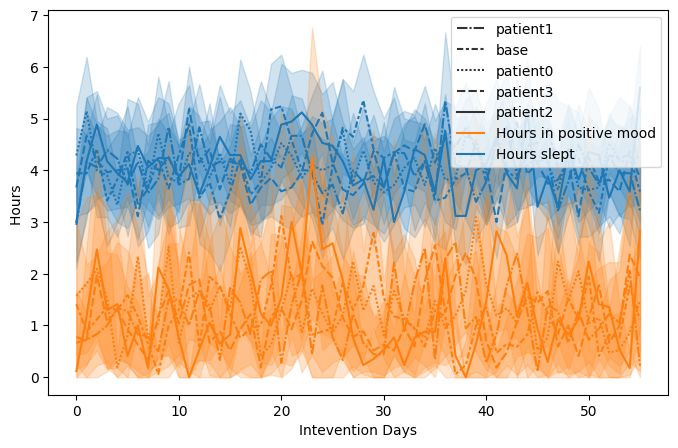

In [12]:
sleep_list = []
positive_list = []
dfs = []

for run in range(0, runs):
    
    patient_profile = random.choice(patient_profiles)
    P = patient_profiles_values[patient_profile]
    env1 = P(behaviour_threshold=20, habituation=habituation, time_preference_update_step=time_preference_update_step )
    action = 0
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        action = 0
    
    
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)
    df = pd.DataFrame()
    df['sleep'] = env1.h_slept
    df['positive'] = env1.h_positive
    df['profile'] = patient_profile
    df.reset_index(inplace=True)
    dfs.append(df)
    
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)

fig = plt.figure( figsize=(8, 5))
sns.lineplot(data=df, y='sleep', x='index', style='profile', label='Hours slept')
sns.lineplot(data=df, y='positive', x='index', style='profile', label='Hours in positive mood')
#plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
#plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(reversed(list(zip(labels, handles))))
plt.legend(by_label.values(), by_label.keys())
    
plt.show()

# Intervention

In [124]:
def intervention_iteration(args):
    run, method, name, condition = args

    performed = 0
    patient_profile = random.choice(patient_profiles)
    P = patient_profiles_values[patient_profile]
        
    env1 = P(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step)
    env1 = method(env1)
    if sum(env1.num_performed):
        performed += 1
    df = pd.DataFrame()
    df['responce_ratio'] = env1.rr
    df['activity performed'] = env1.num_performed
    df['notifications'] = env1.num_notified
    df['sleep'] = env1.h_slept
    df['positive'] = env1.h_positive
    df['non_stationary'] = env1.h_nonstationary
    df['profile'] = patient_profile
    df.reset_index(inplace=True)
    
    df.to_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory, condition, name, run))
    return df.responce_ratio, df.notifications, df.sleep, df.positive, performed, df

def intervention(method, runs, name, condition, processes=10):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    performed = 0
    
    with mp.Pool(processes) as p:
        rr_random_list, not_random_list, sleep_list, positive_list, performed_list, dfs = \
            zip(*tqdm(p.imap(intervention_iteration, [(run, method, name, condition) for run in range(runs)], ceil(runs / processes / 2)), total=runs))
    performed = sum(performed_list)
    df = pd.concat(dfs)
    df.reset_index(drop=True, inplace=True)
    
    print("This figures include runs in which no prompt resulted in the activity being performed")
    print("{0} out of {1} resulted in activity being performed ".format(performed, runs))
    fig = plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, y='sleep', x='index', style='profile', label='Hours slept')
    sns.lineplot(data=df, y='positive', x='index', style='profile', label='Hours in positive mood')
    #plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    #plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(reversed(list(zip(labels, handles))))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
    sns.lineplot(data=df, y='responce_ratio', x='index', style='profile', label='responce rate', ax=ax1)
    sns.lineplot(data=df, y='notifications', x='index', style='profile', label='num notified', ax=ax2)
    #ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
    #ax2.plot(np.nanmean(not_random_list, axis=0), label='num notified')
    ax2.set_xlabel('Intervention Days')
    ax2.set_ylabel('No. notifications')
    ax1.set_ylabel('Responce ratio')
    
    #handles, labels = ax1.get_legend_handles_labels()
    #by_label = dict(reversed(list(zip(labels, handles))))
    #ax1.legend(by_label.values(), by_label.keys())
    
    #handles, labels = ax2.get_legend_handles_labels()
    #by_label = dict(reversed(list(zip(labels, handles))))
    #ax2.legend(by_label.values(), by_label.keys())
    
    plt.show()
    return sleep_list, positive_list, rr_random_list, not_random_list

## Heuristic

Notify every hour except in night and when the patinets is alseep

In [112]:
def always_notify(env1, intervention_legth=eight_weeks):
    
    action = 0
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] == 3 or observation[3] ==1:
            action = 0
        else:
            action = 1
            
    return env1

  0%|          | 0/100 [00:00<?, ?it/s]

This figures include runs in which no prompt resulted in the activity being performed
91 out of 100 resulted in activity being performed 


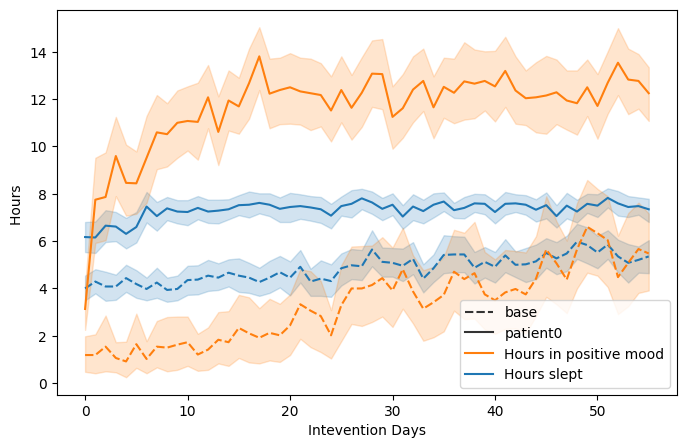

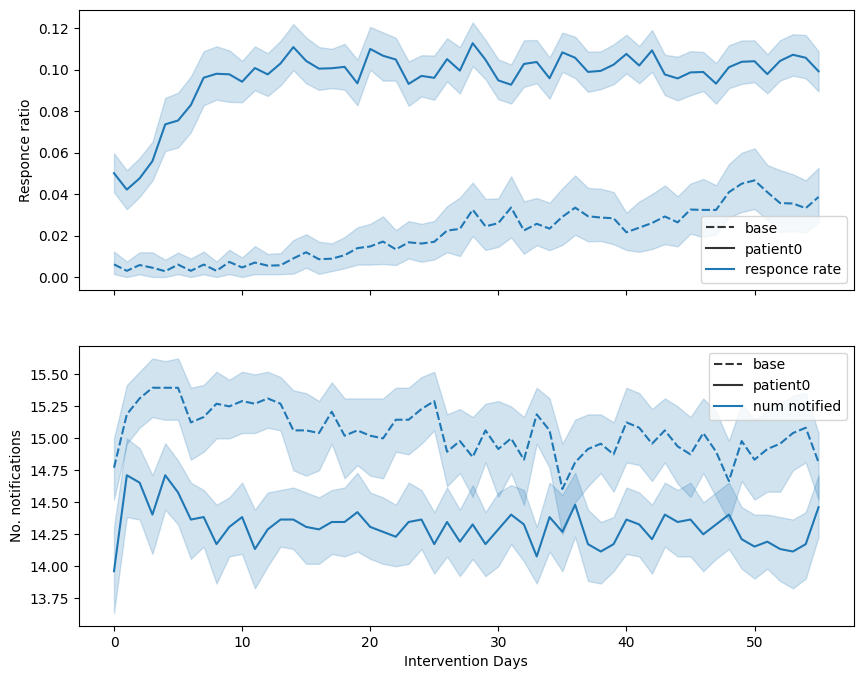

In [113]:
sleep_listh, positive_listh, rr_h_list, not_h_list = intervention(always_notify, runs, 'h', condition)

## Random 
Randomly sample during the day skip the nights

In [114]:
def random_notification(env1, intervention_legth=eight_weeks):
    
    action = 0
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] ==3:
            action = 0
        else:
            action = env1.action_space.sample()
            
    return env1

  0%|          | 0/100 [00:00<?, ?it/s]

This figures include runs in which no prompt resulted in the activity being performed
86 out of 100 resulted in activity being performed 


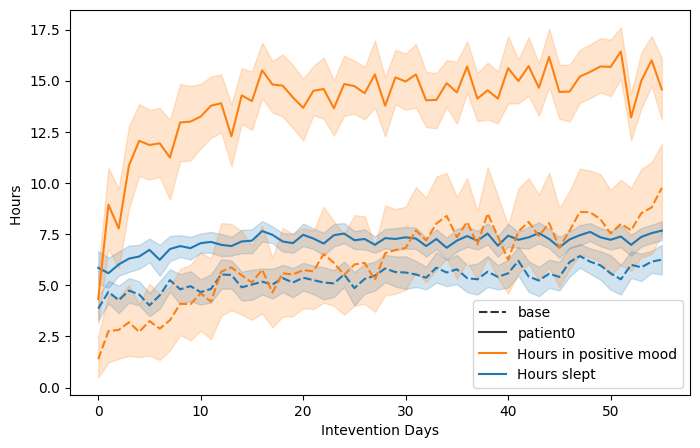

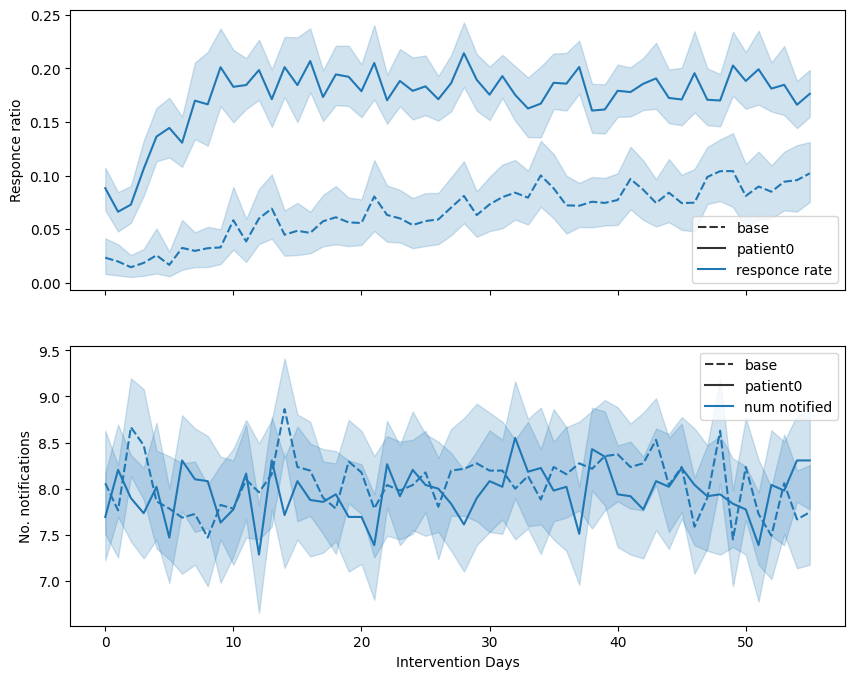

In [115]:
_ = intervention(random_notification, runs, 'random', condition)

In [116]:
def get_rr_and_notification(name, runs, condition):
    
    rr, noti = [],[]
    failed = 0
    for run in range(runs):
        df = pd.read_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory,condition, name, run))
        a_performed = sum(df['activity performed'].values)
        if a_performed > 0: # activity performed at least once in the course of the intervention
            rr.append(df.responce_ratio)
            noti.append(df.notifications)
        else:
            failed = failed +1 
    print(" {0} out of {1} runs had no activity performed throught the full intervention.".format(failed, runs))
    return rr, noti, failed

In [117]:
rr_random_list, not_random_list, fppo = get_rr_and_notification('random', runs, condition)

 14 out of 100 runs had no activity performed throught the full intervention.


## Supervised Learning

### static model

In [125]:
def supervised_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = always_notify(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        
        
    return env1

  0%|          | 0/100 [00:00<?, ?it/s]

This figures include runs in which no prompt resulted in the activity being performed
72 out of 100 resulted in activity being performed 


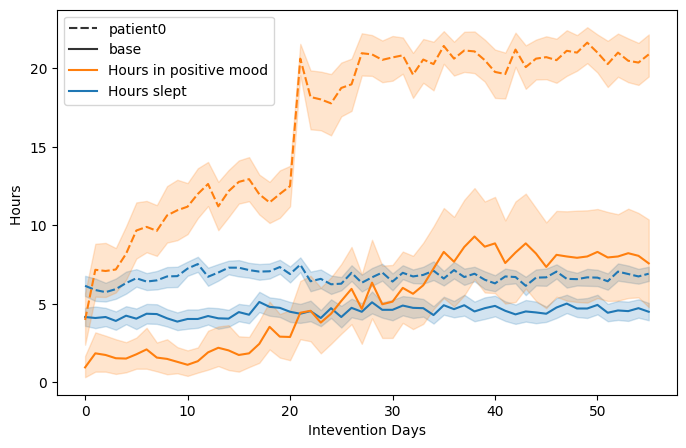

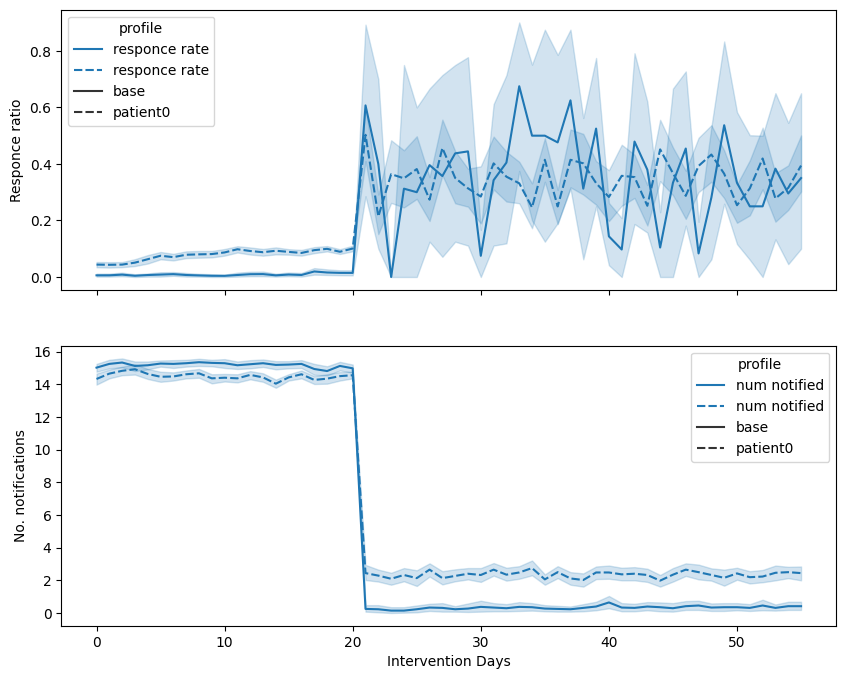

CPU times: user 6.21 s, sys: 1.05 s, total: 7.25 s
Wall time: 59.5 s


In [126]:
%time _ = intervention(supervised_after_three_weeks,runs , 'static_sup3', condition)

### adaptive model 

In [127]:
def supervised_adaptive_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = always_notify(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    samples = len(env1.observation_list)
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        if len(env1.observation_list)> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            clf.fit(env1.observation_list, env1.activity_performed)
            samples = len(env1.observation_list)
            
        
    return env1

  0%|          | 0/100 [00:00<?, ?it/s]

This figures include runs in which no prompt resulted in the activity being performed
85 out of 100 resulted in activity being performed 


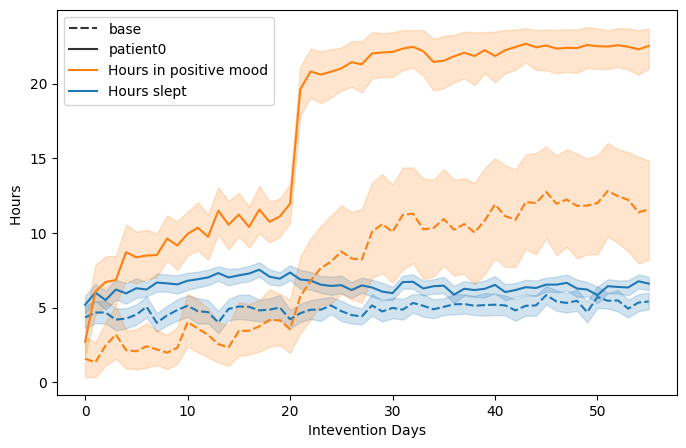

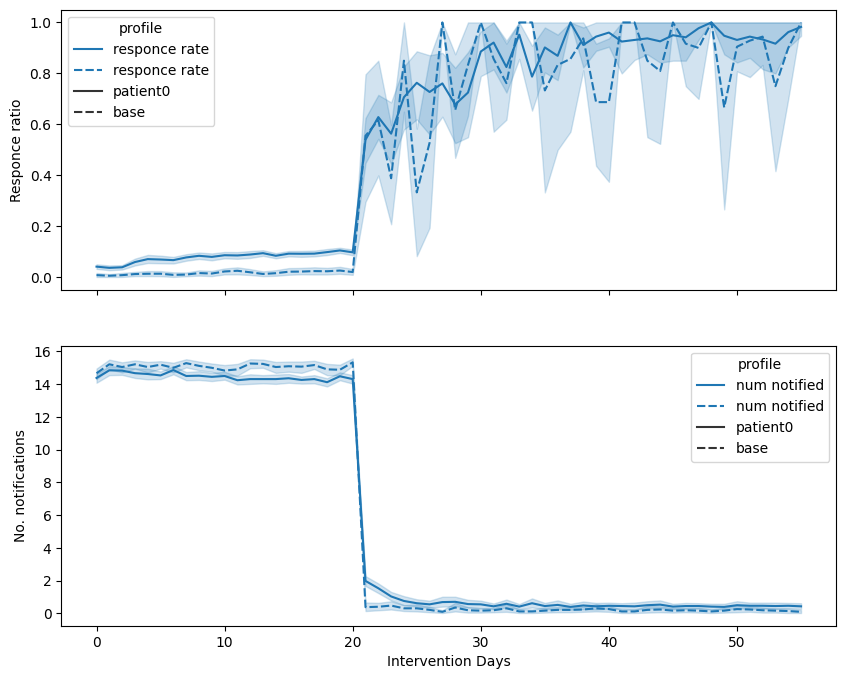

CPU times: user 5.66 s, sys: 1.02 s, total: 6.68 s
Wall time: 1min 20s


In [128]:
%time _ = intervention(supervised_adaptive_after_three_weeks, runs, 'adaptive_sup3', condition)

### How many times supervised training faild?

In [129]:
rr_rf3_list, not_rf3_list, frf3 = get_rr_and_notification('static_sup3', runs, condition)

 28 out of 100 runs had no activity performed throught the full intervention.


In [130]:
rr_rf3a_list, not_rf3a_list, frf3a = get_rr_and_notification('adaptive_sup3', runs, condition)

 15 out of 100 runs had no activity performed throught the full intervention.


## Deep Q Network

In [131]:
def dqn(env1):
    model = DQN("MlpPolicy", env1, verbose=0, learning_starts=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

  0%|          | 0/100 [00:00<?, ?it/s]

This figures include runs in which no prompt resulted in the activity being performed
78 out of 100 resulted in activity being performed 


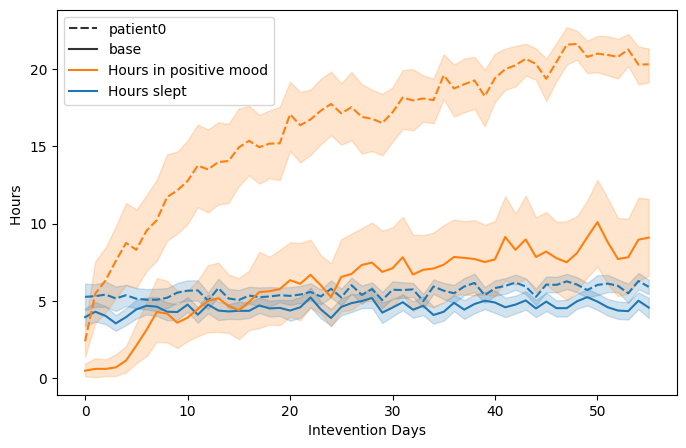

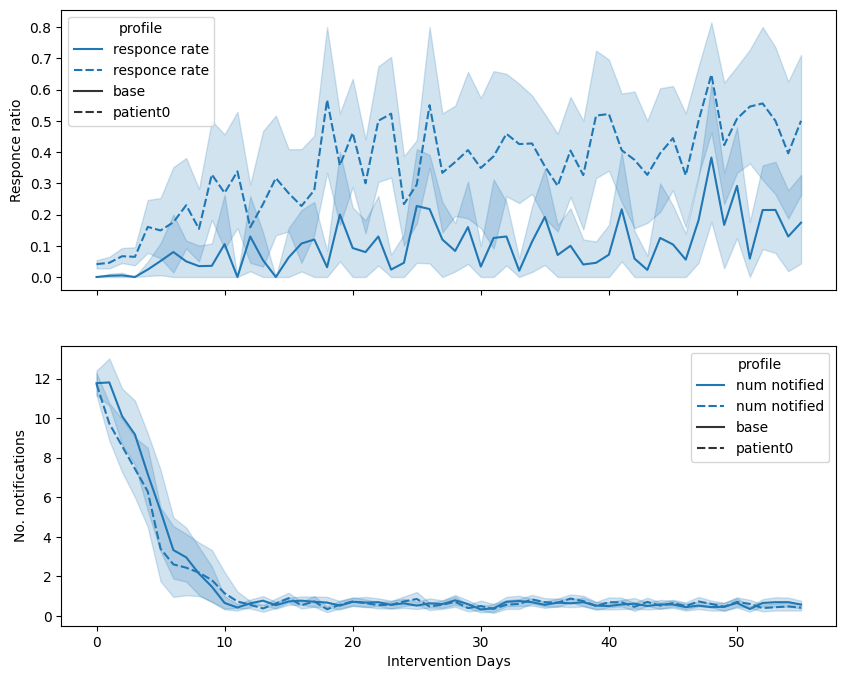

In [132]:
_= intervention(dqn, runs, 'dqn', condition, processes=4) # tylko 4 procesy bo zajmują dużo RAMu i VRAMu

In [133]:
rr_dqn_list, not_dqn_list, fdqn = get_rr_and_notification('dqn', runs, condition)

 22 out of 100 runs had no activity performed throught the full intervention.


## Proximal Policy Optimisation

In [134]:
def ppo(env1):
    model = PPO("MlpPolicy", env1, verbose=0, n_steps=updated_every_day, batch_size=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

  0%|          | 0/100 [00:00<?, ?it/s]

This figures include runs in which no prompt resulted in the activity being performed
78 out of 100 resulted in activity being performed 


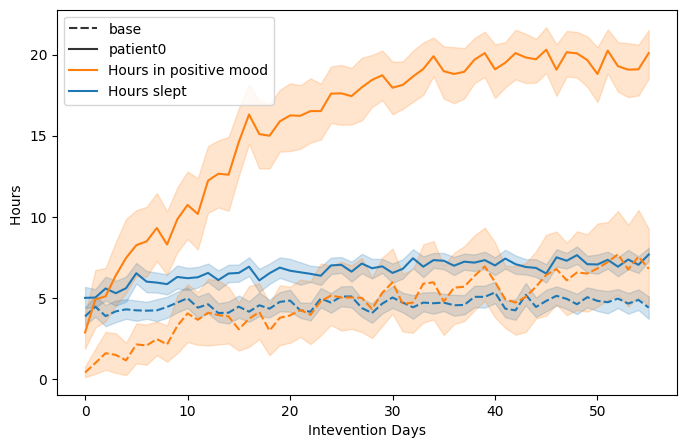

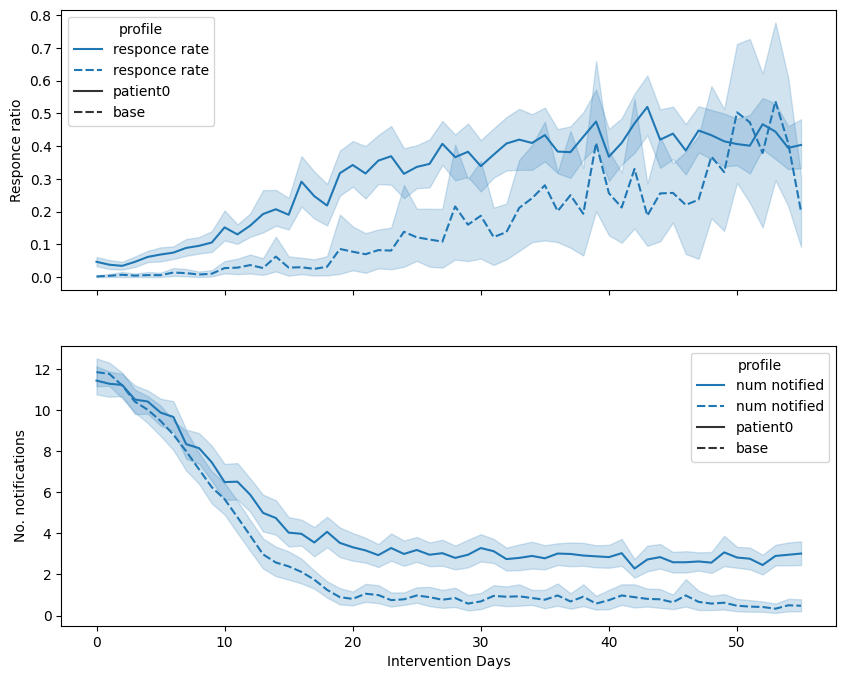

In [135]:
_= intervention(ppo, runs, 'ppo', condition, processes=4)

In [136]:
rr_ppo_list, not_ppo_list, fppo = get_rr_and_notification('ppo', runs, condition)

 22 out of 100 runs had no activity performed throught the full intervention.


## Advantage Actor Critic

In [137]:
def a2c(env1):
    model = A2C("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

  0%|          | 0/100 [00:00<?, ?it/s]

This figures include runs in which no prompt resulted in the activity being performed
94 out of 100 resulted in activity being performed 


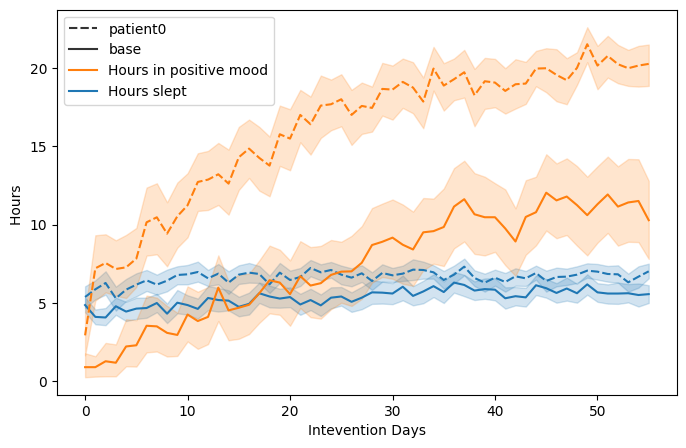

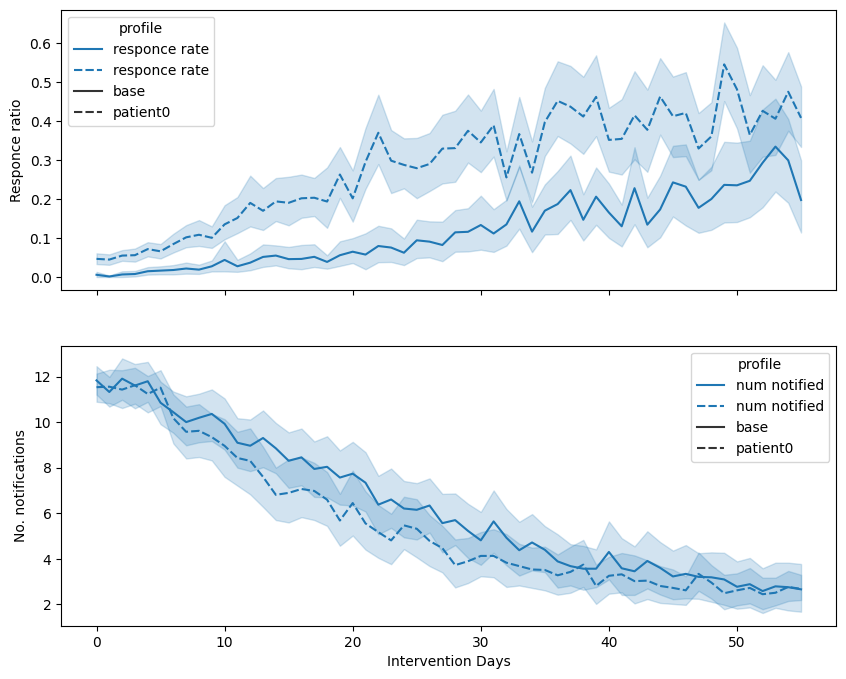

In [138]:
_ = intervention(a2c, runs, 'a2c', condition, processes=4)

In [139]:
rr_a2c_list, not_a2c_list, fppo = get_rr_and_notification('a2c', runs, condition)

 6 out of 100 runs had no activity performed throught the full intervention.


## Comparison between prompt learning stategies

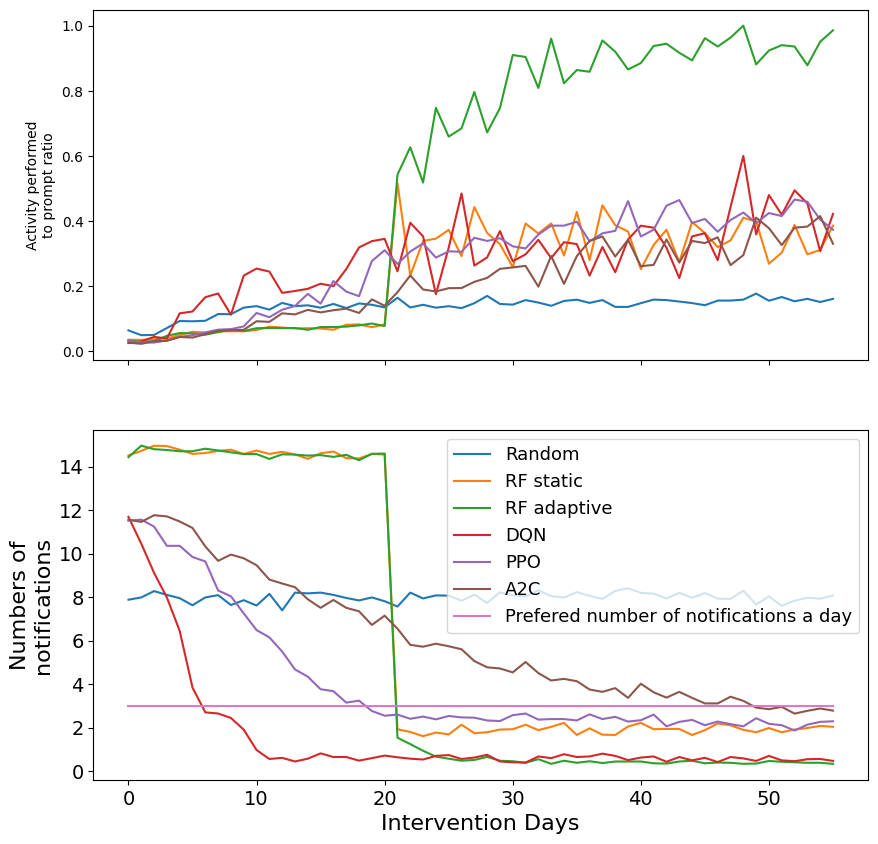

In [140]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,10))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')


ax2.plot(np.nanmean(not_random_list, axis=0), label='Random')
ax2.plot(np.nanmean(not_rf3_list, axis=0), label='RF static')
ax2.plot(np.nanmean(not_rf3a_list, axis=0), label='RF adaptive')
ax2.plot(np.nanmean(not_dqn_list, axis=0), label='DQN')
ax2.plot(np.nanmean(not_ppo_list, axis=0), label='PPO')
ax2.plot(np.nanmean(not_a2c_list, axis=0), label='A2C')
ax2.plot(np.ones(len(np.mean(not_random_list, axis=0))) +2, label ='Prefered number of notifications a day')

ax2.set_xlabel('Intervention Days', fontsize=16)
ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)) )
# ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
# plt.ylim(0, 0.95)
ax2.legend(fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Plots

In [ ]:
runs = 500

#basic stable condition
# condition = 'stable'

#Other options:
# condition = 'habituated'
# condition = 'changed_preference'
condition = 'habituated_changed_preference'

In [ ]:
rr_rf3_list, not_rf3_list, frf3 = get_rr_and_notification('static_sup3', runs, condition)

In [ ]:
rr_rf3a_list, not_rf3a_list, frf3a = get_rr_and_notification('adaptive_sup3', runs, condition)

In [ ]:
rr_dqn_list, not_dqn_list, fdqn = get_rr_and_notification('dqn', runs, condition)

In [ ]:
rr_ppo_list, not_ppo_list, fppo = get_rr_and_notification('ppo', runs, condition)

In [ ]:
rr_a2c_list, not_a2c_list, fa2c = get_rr_and_notification('a2c', runs, condition)

In [ ]:
rr_random_list, not_random_list, frandom = get_rr_and_notification('random', runs, condition)

In [ ]:
shift = 7* 5

In [ ]:
intervention_length = 7*8

In [ ]:
fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10,5))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')
ax1.vlines(shift , 0, 1, linestyles='dashed', color='red', label='preference shift' )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax2 = ax1.twiny()
def tick_function(X):
    V = 20 + 0.15 * X
    return V

new_tick_locations = np.array([0, 20, 27, 47])
ax2.grid(True)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel('$ \it{action}$ $\it{threshold}$', fontsize=14 )
ax1.set_xlabel('Intervention Days', fontsize=16 )
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)), fontsize=16 )
plt.ylim(0, 0.95)
ax1.legend( fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Intervention vs. No Intervention

Simulated patients who habituate to prompts and changes preference to be notified in the evening after 5 weeks of intervention

In [69]:
habituation=False
time_preference_update_step= 99999999
condition = 'habituated_changed_preference'

In [ ]:
sleep_list = []
positive_list = []
walking_list = []

for run in range(0, runs):
    
    env1 = Patient(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step)
    action = 0
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        action = 0
        
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)
    walking_list.append(env1.h_nonstationary)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.plot(np.mean(walking_list, axis=0), label='Hours active')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

In [71]:
def get_patient_state_progress(condition, name, runs):
    
    walking = []
    sleeping = []
    positive = []
    for run in range(runs):
        df = pd.read_csv('{3}/patient1_{0}_{1}_run{2}.csv'.format(condition, name, run, results_directory))
        a_performed = sum(df['activity performed'].values)
        if a_performed >0:
            walking.append(df.non_stationary)
            sleeping.append(df.sleep)
            positive.append(df.positive)
    return walking, sleeping, positive
    

In [ ]:
walkingh, sleep_listh, positive_listh = get_patient_state_progress(condition, 'h', runs)

In [ ]:
walking_ppo, sleep_list_ppo, positive_list_ppo = get_patient_state_progress(condition, 'ppo', runs)

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(16, 4))
ax[0].plot(np.nanmean(sleep_list, axis=0), label='Slept', color ='r')
ax[0].plot(np.mean(positive_list, axis=0), label='In positive mood')
ax[0].plot(np.mean(walking_list, axis=0), label='Non-stationary activity')
ax[1].plot(np.nanmean(sleep_listh, axis=0), label='Hours slept', color ='r')
ax[1].plot(np.mean(positive_listh, axis=0), label='Hours in positive mood')
ax[1].plot(np.mean(walkingh, axis=0), label='Active')
ax[2].plot(np.nanmean(sleep_list_ppo, axis=0), label='Hours slept', color ='r')
ax[2].plot(np.mean(positive_list_ppo, axis=0), label='Hours in positive mood')
ax[2].plot(np.mean(walking_ppo, axis=0), label='Active')
ax[0].set_ylabel('Hours', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Intevention Days', fontsize=14)
ax[1].set_xlabel('Intevention Days', fontsize=14)
ax[2].set_xlabel('Intevention Days', fontsize=14)
ax[0].set_title('No intervention', fontsize=14)
ax[1].set_title('Intervention with hourly prompts', fontsize=14)
ax[2].set_title("Intervention with 'timely' prompts", fontsize=14)